# Weighted Max-Cut via Tabu Search

This notebook implements a clean, fully runnable Tabu Search for the **weighted** Max-Cut problem using only common Python packages.


## 1) Problem setup

Given an undirected weighted graph **G = (V, E)** with weights **w(u,v)** and a bitstring **x in {0,1}^n**, the **Max-Cut** objective is:

$$
F(x) = \sum_{(u,v) \in E} w(u,v) \, \mathbf{1}[x_u \neq x_v]
$$

We seek **x** that maximizes **F(x)**.


In [ ]:
import time
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8, 4)

def derive_seeds(seed):
    # Standardized seed offsets per algorithm/instance.
    return {
        "instance_seed": seed,
        "algo_seed": seed + 10_000,
        "random_seed": seed + 20_000,
        "greedy_seed": seed + 30_000,
    }


## 2) Random instance generator


In [ ]:
def generate_graph(n, p, weighted=True, w_low=1, w_high=10, seed=None):
    #to generate an Erdos-Renyi graph and optionally integer edge weights.
    G = nx.erdos_renyi_graph(n, p, seed=seed)
    if weighted:
        rng = np.random.default_rng(seed)
        for u, v in G.edges():
            G[u][v]["weight"] = int(rng.integers(w_low, w_high + 1))
    return G


## 3) Reference evaluator (for debugging)


In [ ]:
def cut_value(G, x, node_list=None, node_index=None):
    #calculate cut value by iterating edges: works for both weighted/unweighted graphs!
    if node_list is None:
        node_list = list(G.nodes())
    if node_index is None:
        node_index = {v: i for i, v in enumerate(node_list)}
    total = 0
    for u, v, data in G.edges(data=True):
        w = data.get("weight", 1)
        if x[node_index[u]] != x[node_index[v]]:
            total += w
    return total


## 4) Efficient Tabu Search


In [4]:
def delta_init(G, x, node_list=None, node_index=None):
    # Initial gain vector: delta[v] = F(x with v flipped) - F(x).
    if node_list is None:
        node_list = list(G.nodes())
    if node_index is None:
        node_index = {v: i for i, v in enumerate(node_list)}

    n = len(node_list)
    delta = np.zeros(n, dtype=float)
    for v in node_list:
        iv = node_index[v]
        s = 0.0
        for u, data in G.adj[v].items():
            w = data.get("weight", 1)
            iu = node_index[u]
            s += w * (1 if x[iu] == x[iv] else -1)
        delta[iv] = s
    return delta


In [5]:
def tabu_search_maxcut(
    G,
    max_iters=5000,
    tenure=10,
    seed=0,
    patience=1000,
    sanity_check=False,
    check_every=100,
):
    # Tabu Search for Max-Cut.
    # - x is a 0/1 numpy vector aligned with node_list
    # - delta[v] = gain if we flip v
    # - tabu_until[v] stores the earliest iteration when v becomes admissible
    node_list = list(G.nodes())
    node_index = {v: i for i, v in enumerate(node_list)}
    n = len(node_list)

    rng = np.random.default_rng(seed)
    x = rng.integers(0, 2, size=n, dtype=int)

    F = cut_value(G, x, node_list, node_index)
    delta = delta_init(G, x, node_list, node_index)

    best_x = x.copy()
    best_F = F
    best_history = []

    tabu_until = np.zeros(n, dtype=int)
    last_improve_iter = 0

    for it in range(max_iters):
        # Choose best admissible move (aspiration allowed)
        best_v = None
        best_gain = -np.inf
        for v in range(n):
            gain = delta[v]
            admissible = (it >= tabu_until[v]) or (F + gain > best_F)
            if admissible and gain > best_gain:
                best_gain = gain
                best_v = v

        if best_v is None:
            break

        old_xv = x[best_v]
        x[best_v] = 1 - x[best_v]
        F = F + delta[best_v]
        tabu_until[best_v] = it + tenure

        # Update deltas efficiently
        delta[best_v] = -delta[best_v]
        v_node = node_list[best_v]
        for u, data in G.adj[v_node].items():
            w = data.get("weight", 1)
            iu = node_index[u]
            if x[iu] != old_xv:
                delta[iu] += 2 * w
            else:
                delta[iu] -= 2 * w

        if sanity_check and (it % check_every == 0):
            assert F == cut_value(G, x, node_list, node_index)

        if F > best_F:
            best_F = F
            best_x = x.copy()
            last_improve_iter = it

        best_history.append(best_F)
        if it - last_improve_iter >= patience:
            break

    return {
        "best_x": best_x,
        "best_F": int(best_F),
        "final_x": x.copy(),
        "final_F": int(F),
        "iters": it + 1,
        "best_history": best_history,
    }


### Baselines: random search and greedy hill-climb


In [6]:
def random_search(G, num_samples=500, seed=0):
    # Random assignments; return best cut found.
    node_list = list(G.nodes())
    node_index = {v: i for i, v in enumerate(node_list)}
    n = len(node_list)
    rng = np.random.default_rng(seed)

    best_F = -np.inf
    best_x = None
    for _ in range(num_samples):
        x = rng.integers(0, 2, size=n, dtype=int)
        F = cut_value(G, x, node_list, node_index)
        if F > best_F:
            best_F = F
            best_x = x
    return {"best_x": best_x, "best_F": int(best_F), "final_x": best_x, "final_F": int(best_F), "iters": num_samples}


def greedy_hill_climb(G, seed=0, max_iters=2000):
    # Best-improving single-flip local search (no tabu).
    node_list = list(G.nodes())
    node_index = {v: i for i, v in enumerate(node_list)}
    n = len(node_list)
    rng = np.random.default_rng(seed)
    x = rng.integers(0, 2, size=n, dtype=int)

    F = cut_value(G, x, node_list, node_index)
    delta = delta_init(G, x, node_list, node_index)

    for it in range(max_iters):
        v = int(np.argmax(delta))
        if delta[v] <= 0:
            return {"best_x": x, "best_F": int(F), "final_x": x, "final_F": int(F), "iters": it + 1}

        old_xv = x[v]
        x[v] = 1 - x[v]
        F = F + delta[v]
        delta[v] = -delta[v]

        v_node = node_list[v]
        for u, data in G.adj[v_node].items():
            w = data.get("weight", 1)
            iu = node_index[u]
            if x[iu] != old_xv:
                delta[iu] += 2 * w
            else:
                delta[iu] -= 2 * w

    return {"best_x": x, "best_F": int(F), "final_x": x, "final_F": int(F), "iters": max_iters}


## 5) Experiments

We run small experiments across a grid of sizes and densities. For speed, the Tabu Search max iterations is reduced during the grid run.


In [7]:
# Experiment grid
n_values = [50, 100, 200]
p_values = [0.1, 0.3]
tenures = [5, 10, 20]
seeds = list(range(10))

rows = []

for n in n_values:
    for p in p_values:
        for seed in seeds:
            G = generate_graph(n, p, weighted=True, seed=seed)

            # Random baseline
            t0 = time.perf_counter()
            r = random_search(G, num_samples=300, seed=seeds_map["random_seed"])
            rows.append({
                "n": n, "p": p, "tenure": None, "seed": seed, "method": "random",
                "best_F": r["best_F"], "final_F": r["final_F"], "iters": r["iters"],
                "seconds": time.perf_counter() - t0,
            })

            # Greedy baseline
            t0 = time.perf_counter()
            g = greedy_hill_climb(G, seed=seeds_map["greedy_seed"], max_iters=2000)
            rows.append({
                "n": n, "p": p, "tenure": None, "seed": seed, "method": "greedy",
                "best_F": g["best_F"], "final_F": g["final_F"], "iters": g["iters"],
                "seconds": time.perf_counter() - t0,
            })

            # Tabu Search across tenures
            for tenure in tenures:
                t0 = time.perf_counter()
                t = tabu_search_maxcut(G, max_iters=2000, tenure=tenure, seed=seeds_map["algo_seed"], patience=500)
                rows.append({
                    "n": n, "p": p, "tenure": tenure, "seed": seed, "method": "tabu",
                    "best_F": t["best_F"], "final_F": t["final_F"], "iters": t["iters"],
                    "seconds": time.perf_counter() - t0,
                })

results = pd.DataFrame(rows)
results.head()


,n,p,tenure,seed,method,best_F,final_F,iters,seconds
0,50,0.1,NaN,0,random,552,552,300,0.025798
1,50,0.1,NaN,0,greedy,654,654,16,0.000942
2,50,0.1,5.0,0,tabu,680,677,524,0.006426
3,50,0.1,10.0,0,tabu,680,663,524,0.005191
4,50,0.1,20.0,0,tabu,680,615,524,0.005693


### Plots


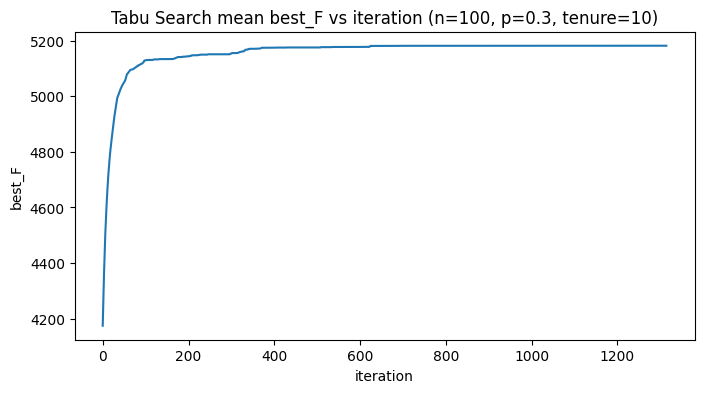

In [9]:
# a) Mean best_F vs iteration for a chosen setting
chosen_n, chosen_p, chosen_tenure = 100, 0.3, 10

histories = []
for seed in seeds:
    seeds_map = derive_seeds(seed)
    G = generate_graph(chosen_n, chosen_p, weighted=True, seed=seeds_map["instance_seed"])
    out = tabu_search_maxcut(G, max_iters=2000, tenure=chosen_tenure, seed=seeds_map["algo_seed"], patience=500)
    histories.append(out["best_history"])

max_len = max(len(h) for h in histories)
H = np.zeros((len(histories), max_len))
for i, h in enumerate(histories):
    last = h[-1]
    H[i, :len(h)] = h
    H[i, len(h):] = last

mean_curve = H.mean(axis=0)

plt.plot(mean_curve)
plt.title(f"Tabu Search mean best_F vs iteration (n={chosen_n}, p={chosen_p}, tenure={chosen_tenure})")
plt.xlabel("iteration")
plt.ylabel("best_F")
plt.show()


<Figure size 700x400 with 0 Axes>

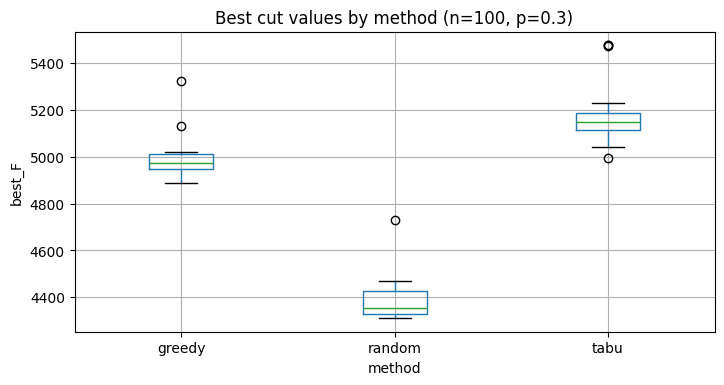

In [10]:
# b) Boxplot of best_F across methods (fixed setting)
subset = results[(results["n"] == 100) & (results["p"] == 0.3)].copy()

plt.figure(figsize=(7, 4))
subset.boxplot(column="best_F", by="method")
plt.suptitle("")
plt.title("Best cut values by method (n=100, p=0.3)")
plt.ylabel("best_F")
plt.show()


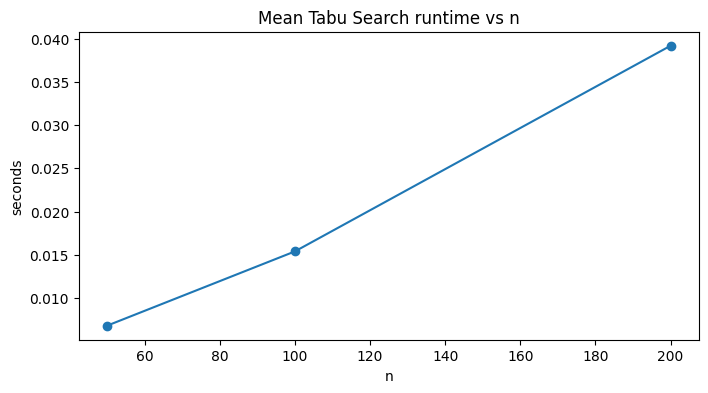

In [11]:
# c) Runtime vs n (Tabu, mean over seeds and p)
tabu_only = results[results["method"] == "tabu"]
mean_runtime = tabu_only.groupby(["n"])["seconds"].mean()

plt.plot(mean_runtime.index, mean_runtime.values, marker="o")
plt.title("Mean Tabu Search runtime vs n")
plt.xlabel("n")
plt.ylabel("seconds")
plt.show()


## 6) Example output


In [ ]:
# Run one example instance and print the partition
seeds_map = derive_seeds(42)
G = generate_graph(50, 0.2, weighted=True, seed=seeds_map["instance_seed"])
res = tabu_search_maxcut(G, max_iters=3000, tenure=10, seed=seeds_map["algo_seed"], patience=800)

node_list = list(G.nodes())
A = [node_list[i] for i, bit in enumerate(res["best_x"]) if bit == 0]
B = [node_list[i] for i, bit in enumerate(res["best_x"]) if bit == 1]

print("best cut value:", res["best_F"])
print("|A|=", len(A), "|B|=", len(B))
print("A:", A)
print("B:", B)


best cut value: 954
|A|= 24 |B|= 26
A: [0, 1, 2, 6, 7, 9, 12, 14, 15, 17, 21, 22, 23, 27, 29, 31, 34, 35, 36, 38, 39, 45, 46, 48]
B: [3, 4, 5, 8, 10, 11, 13, 16, 18, 19, 20, 24, 25, 26, 28, 30, 32, 33, 37, 40, 41, 42, 43, 44, 47, 49]
